In [14]:
#!pip install matplotlib
#!pip install mplcyberpunk
#!pip install setuptools
from matplotlib import pyplot as plt
import math
import mplcyberpunk

plt.style.use("cyberpunk")


# Analisys for the WATTIMETER

This is a ESP32 project aimed to provide power consumption information for the network. 

The project will use:
* ESP32
* ACS712

## For the current sensing - ACS712
The project will use the ACS712 current sensor to be able to measure the current.
The ACS712 has very specific voltage-current graph as show bellow:


![acs712](current_sensor.png)

Since the 0A is exactly at 2.5V for the output, we will need to adjust our code. I have no intention of moving this values to increase resolution, the reason behind it is to minimise components in the circuitry.

The equation for the current is:
$$
A = \frac{(A_1 + A_2 + A_3 + ... + A_n)}{A_n}
$$

For the Arms the equation is:
$$
A_{rms} = \sqrt{\frac{A_1^2 + A_2^2 + A_3^2 + ... + A_n^2}{n}}
$$

For the ADC in the ESP32 we need to be able to read the actual current value, so we know that:
* ESP32 adc has 3.3v
* 12bit adc 4095

This means we have better resolution setting up oue sensor to read negative current, from 0A to -30A

The equation for the datasheet graph is:
$$
V = A*0.1 + 2.5
$$

## Adequate signal
The output signal varies from 0-5V, the ESP32 adc uses 0-3.3v so its needed to divide decrease the 5v to 3.3v.

## Voltage divider
$$
V_{out} = V_{in}\frac{R_2}{R_1+R_2}
$$

## Equation
$$
V_{out} = V_{in}\frac{R_2}{R_1+R_2}\\

V_{out}(R_1+R_2) = V_{in}R_2\\

V_{out}R_1 = R_2(V_{in}-V_{out})\\

R_2=\frac{V_{out}R_1}{V_{in}-V_{out}}\\
$$

In [15]:
# Calculating the voltage divider for the ADC,
# Vout = Vin * R2 / (R1 + R2)
Vin = 5
Vout = 3.3
R1 = 10000 # 10k
R2 = (Vout * R1) / (Vin - Vout)
print("Theoretical R2 = ", R2)

# Calculating the voltage divider for the ADC, with real Resistor values
R1 = 10000 # 10k
R2 = 22000 # 22k
Vout = Vin * R2 / (R1 + R2)
print("Real Vout = ", Vout)

# The gain for the voltage divider is
Gain = R2 / (R1 + R2)
print("Gain = ", Gain)

Theoretical R2 =  19411.76470588235
Real Vout =  3.4375
Gain =  0.6875


## ESP32 adc
For the esp32 adc to be able to read correct values:
```
Vadc = Raw * 3.3 / 4095
A = (Vadc - 2.5)/0.1
```

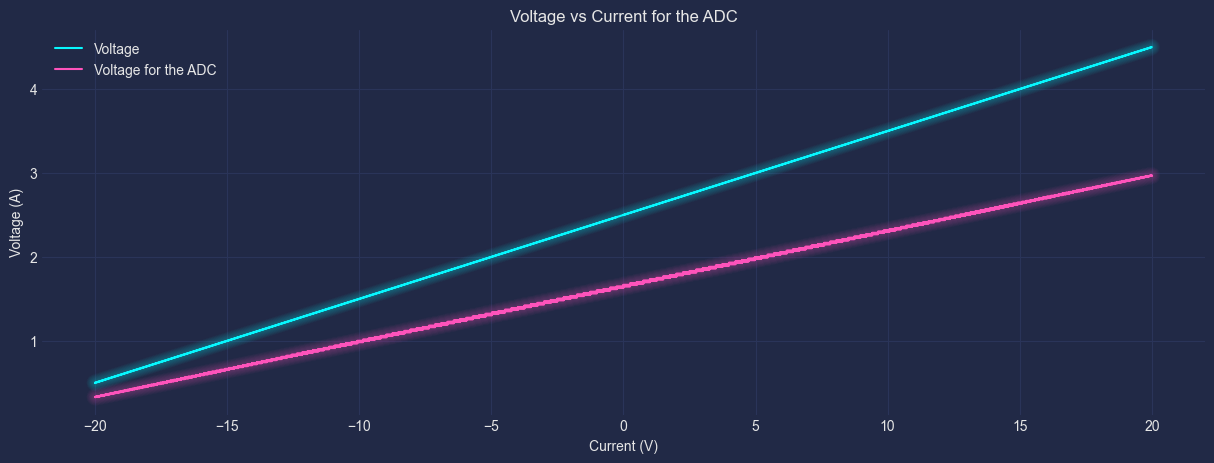

In [16]:
A = []
V = []
Vadc = []
f = 60
t = 1/f
Res = 1000

for i in range(0, Res):
    A.append(20 * math.sin(2*math.pi*f*i/(30*Res)))
    V.append(A[i]*0.1 + 2.5)    
    Vadc.append((A[i]*0.1 + 2.5)*0.66)    


fig = plt.figure()
fig.set_size_inches(15, 5)
plt.plot(A, V)
plt.step(A, Vadc)
plt.legend(['Voltage', 'Voltage for the ADC'])
plt.title('Voltage vs Current for the ADC')
plt.xlabel('Current (V)')
plt.ylabel('Voltage (A)')

mplcyberpunk.make_lines_glow()
plt.show()

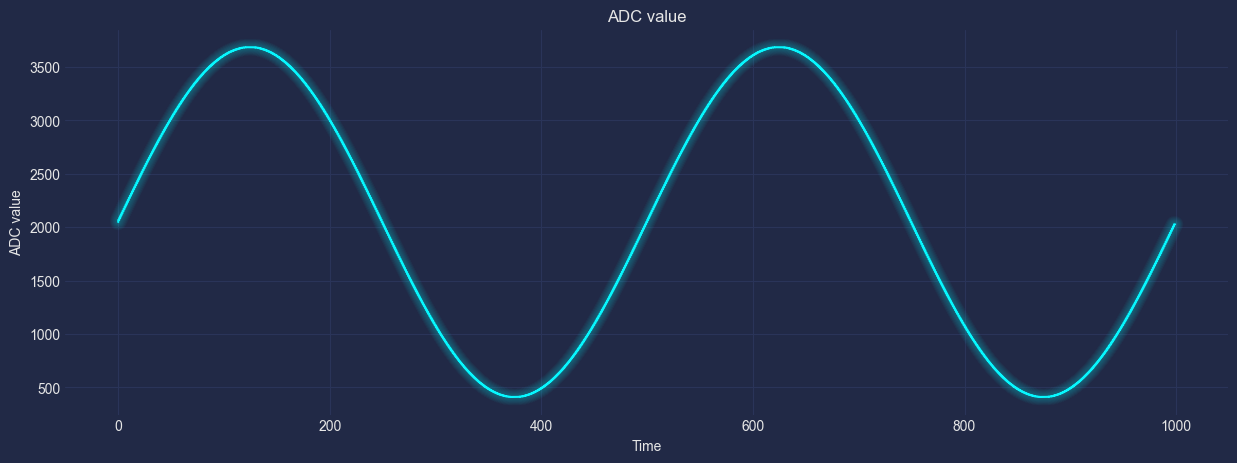

In [17]:
# Lets convert the current graph to a adc value
adc = []
for i in range(0, Res):
    adc.append(int(Vadc[i]*4095/3.3))

fig = plt.figure()
fig.set_size_inches(15, 5)
plt.step(range(0, Res), Vadc)
plt.title('ADC value')
plt.xlabel('Time')
plt.ylabel('ADC value')

mplcyberpunk.make_lines_glow()
plt.show() 

# Voltage Sensing
For the Voltage sensing will be used a rectifier with a voltage divider.
The voltage divider have a gain of 1/69 

$$
V_{out} = V_{in}\frac{R_1}{R_2+R_1}
$$
* $R_1 = 1k\Omega$
* $R_2 = 68k\Omega$

## The Full Bridge rectifier
![rectifer](voltage_sensor.png)

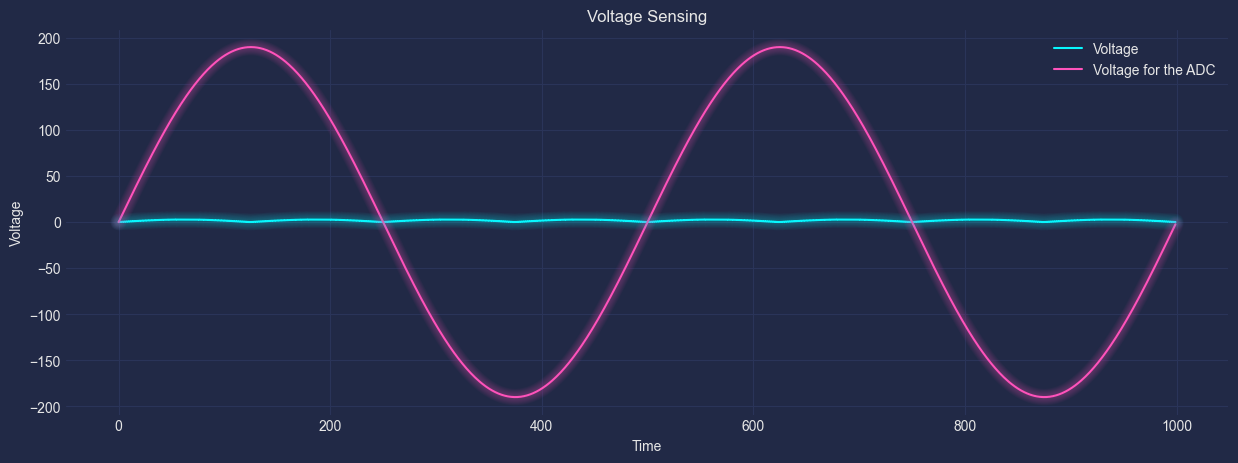

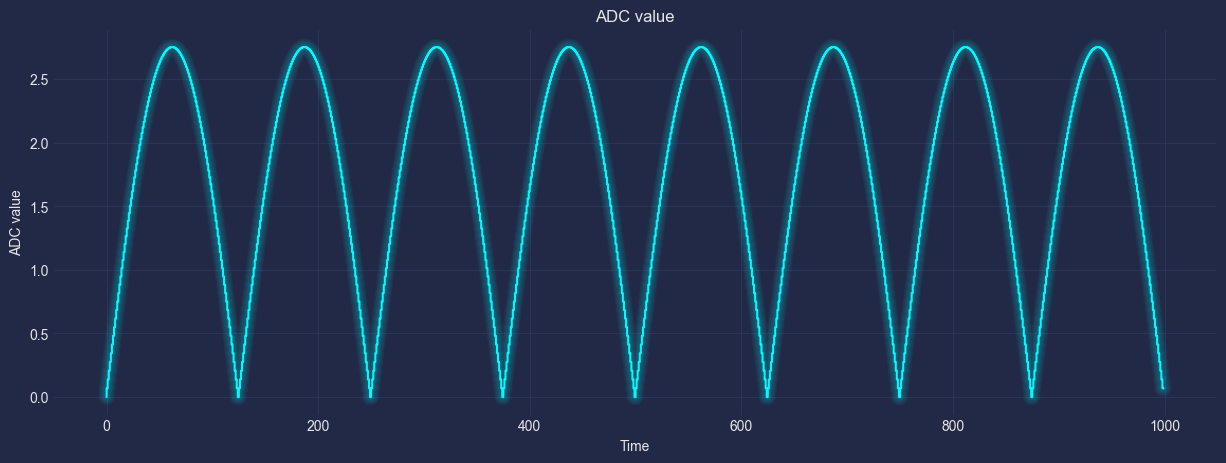

In [18]:
#Simulation
V = []
Vadc = []
f = 60
frect = 2*f
Res = 1000
gain = 1/69

for i in range(0, Res):
    V.append(189.90 * math.sin(2*math.pi*f*i/(30*Res)))
    aux = 189.90 * math.sin(2*math.pi*frect*i/(30*Res))*gain
    if aux < 0:
        Vadc.append(-aux)
    else:
        Vadc.append(aux) 

fig = plt.figure()
fig.set_size_inches(15, 5)
plt.step(range(0,Res),Vadc)
plt.plot(V)
plt.legend(['Voltage', 'Voltage for the ADC'])
plt.title('Voltage Sensing')
plt.xlabel('Time')
plt.ylabel('Voltage')

mplcyberpunk.make_lines_glow()
plt.show()

fig = plt.figure()
fig.set_size_inches(15, 5)
plt.step(range(0, Res), Vadc)
plt.title('ADC value')
plt.xlabel('Time')
plt.ylabel('ADC value')

mplcyberpunk.make_lines_glow()
plt.show()


## The equation for the Voltage sensing adc

```
V_adc = Raw * 3.3 / 4095
V = V_adc*69
```